<a href="https://colab.research.google.com/github/maciejskorski/new_pll_trng/blob/main/TRNG_Dependency_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data



In [8]:
# update Python software - and restart the kernel when necessary
!pip install --upgrade statsmodels --quiet
!pip install mlflow --quiet
!pip install pyngrok --quiet

     |████████████████████████████████| 745 kB 7.8 MB/s 


In [13]:
# Download the zipped files from the shared internet link:
!curl -L "https://filesender.renater.fr/download.php?token=c4a56006-e8f9-4d78-9357-d4540b99e185&files_ids=17941252" --output data_v1.zip
!unzip -q data_v1.zip -d data_v1
!curl -L "https://filesender.renater.fr/download.php?token=76f39908-16e7-4b6b-b497-5849066c7641&files_ids=17983818" --output data_v2.zip
!unzip -q data_v2.zip -d data_v2
!curl -L "https://filesender.renater.fr/download.php?token=1edb5a92-296e-4833-b71d-86e17568aeba&files_ids=17988708" --output data_v3.zip
!unzip -q data_v3.zip -d data_v3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5838k  100 5838k    0     0   419k      0  0:00:13  0:00:13 --:--:--  460k
replace data_v1/220927_CVa2/acq_20220927232404_cnt.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.5M  100 13.5M    0     0   446k      0  0:00:31  0:00:31 --:--:--  459k
replace data_v2/PR_Card_2/220928_CVa1/acq_20220928223348_rng.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7022k  100 7022k    0     0   423k      0  0:00:16  0:00:16 --:--:--  462k


In [ ]:
path = 'data_v2/PR_Card_7/220928_CVa4/log_20220928215356_rng.txt'
with open(path) as f:
  out = f.readlines()
print(''.join(out))


Motherboard vers.: 9
Motherboard sub vers.: 5

HEX Status register        0950226D05A30B00

    HEX D_board version: 09.50
    HEX Allan variance:  226D
    HEX Mean:            05A3
    HEX eq_max:          0B
    HEX eq_cur:          00

Decimal values:
    Mean:                90.1875
    Allan variance:      2.151611328125
    Eq_max:              11

HEX Status2 register       017001170A304210

    HEX KM: 0170
    HEX KD: 0117
    HEX RO freq: 0A30
    HEX warnings: 2
    HEX errors: 10

    BIN warnings: 01000000
    BIN environment warning: 0
    BIN mean warning: 1

    BIN error lock0: 0
    BIN error lock1: 0
    BIN error max: 0
    BIN error overflw: 0
    BIN error var: 1

    RO frequency: 260.8 MHz
    DEC KM: 368
    DEC KD: 279
    DEC Nb of outputs: 4



# Analysis Module

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from IPython.display import display
from pathlib import Path
import logging


plt.rcParams['figure.figsize'] = (10,3)
logger = logging.getLogger('TRNG Analysis')
logger.setLevel(logging.INFO)


def get_bytes_data(fpath):
  with open(fpath,'rb') as f:
    bytes_data = f.read()
  bytes_data = pd.DataFrame(list(bytes_data),columns=['byte value'])
  bytes_data.index.name = 'time'
  return bytes_data


def last_bit(x):
  return x % 2

def last_bit_diff(x):
  return x.diff().loc[1:] % 2


def analyze_series(bytes_data, nlags=10, alpha=0.05, postprocess_fn=last_bit):
  """ Analyze dependencies of TRNG bytes candidate.
      Args:
          bytes_data (pandas.Series): series of raw bytes (das), encoded as integers uint8
          nlags (int): maximum number of lags to analyse
          alpha (float): confidence level for hypothesis testing
          postprocess_fn (function): transform applied to the series. For example, use <mod 2> to extract the last significant bit
      Return:
          figure: picture with plots
  """
  mlflow.log_params(
    {
        'lags':nlags,
        'alpha':alpha,
        'postprocess_fn':postprocess_fn.__name__
    }
  )
  bytes_data = postprocess_fn(bytes_data)
  fig,axs = plt.subplots(1,2,constrained_layout=True)
  # plot histogram
  ax = axs[0]
  sns.histplot(data=bytes_data,x='byte value',ax=ax,discrete=True)
  # plot time series
  ax = axs[1]
  sns.lineplot(data=bytes_data.loc[:1000],x='time',y='byte value',ax=ax)
  plt.show()
  mlflow.log_figure(fig,'exploratory.png')
  # stationarity tests
  results = kpss(bytes_data,nlags=10)
  pval = results[1]
  mlflow.log_metric(f'stationary.KPSS.lag_{nlags}',pval)
  results = adfuller(bytes_data,maxlag=10,store=True)
  pval = results[1]
  mlflow.log_metric(f'not-stationary.ADF.lag_{nlags}',pval)
  # plot autocorelation
  fig,ax = plt.subplots(1,1,constrained_layout=True)
  fig = plot_acf(x=bytes_data, lags = nlags, fft=True, alpha=alpha, bartlett_confint=True, zero=False, adjusted=True, ax=ax, auto_ylims=True)
  ax.set(xlabel='Lag',ylabel='Corr')
  plt.show()
  mlflow.log_figure(fig,'autocorrelation.png')
  # find p-values for autocorrelation
  _,_,_,pvals = acf(
          x=bytes_data,
          nlags=nlags,
          alpha=alpha,
          fft=True,
          bartlett_confint=True,
          adjusted=True,
          qstat=True
  )
  pvals = {'lag':np.arange(1,nlags+1),'Ljung-Box Test p-val':pvals}
  pvals = pd.DataFrame(data=pvals)
  pvals.set_index('lag',inplace=True)
  display(pvals)
  mlflow.log_metric(f'not-correlated.LjungBox.lag_{nlags}',pvals.loc[nlags])

# Results

Overall, I see strong negative correlation	😞. For example:

In [6]:
import numpy as np
import scipy
from scipy import stats
path = '/content/data_v1/220928_CVa1/acq_20220928102506_cnt.bin'
x = np.fromfile(path,dtype='uint8')
print(x.mean())
corr,pval = scipy.stats.pearsonr(x[:-1],x[1:])
print(f'Correlation={corr}, non-corr p-val={pval}')
 # small p-value means correlation! 

137.387392
Correlation=-0.001584791808795311, non-corr p-val=0.1130140482280478


In [9]:
y = x%2
corr,pval = scipy.stats.pearsonr(y[:-1],y[1:])
print(f'Correlation={corr}, non-corr p-val={pval}')

Correlation=-0.00302344405576716, non-corr p-val=0.002499138948651991


## Logging

In [19]:
import mlflow
from pyngrok import ngrok
from getpass import getpass

# run mlflow server
get_ipython().system_raw("mlflow ui --port 5000 &")

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True,
                             auth="best_pll_trng:Hubert Curien"
                             )
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

Enter the ngrok authtoken: ··········
MLflow Tracking UI: https://a427-34-125-212-74.ngrok.io


## Experiments

INFO:TRNG Analysis:Doing experiment data_v1/220928_CVa1


data_v1/220928_CVa1


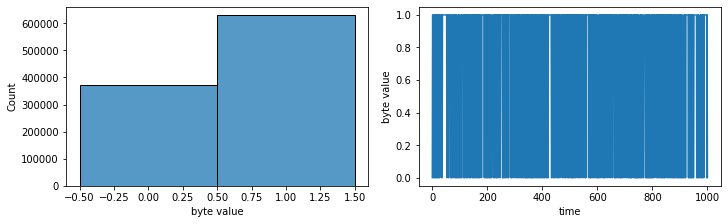

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


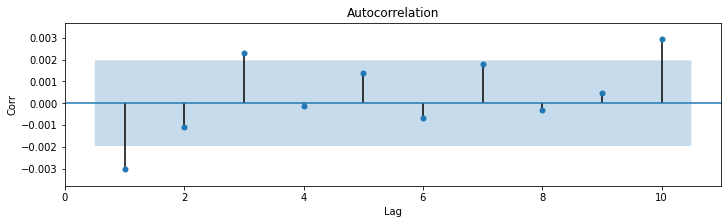

,Ljung-Box Test p-val
lag,
1,0.002499
2,0.005788
3,0.001353
4,0.003530
5,0.003546
6,0.006223
7,0.003487
8,0.006415
9,0.010561


INFO:TRNG Analysis:Doing experiment data_v1/220928_CVa1


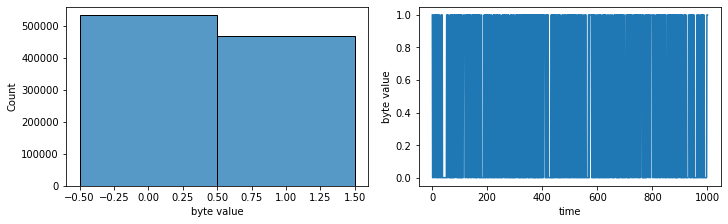

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


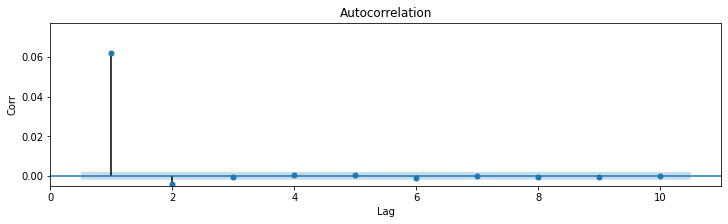

,Ljung-Box Test p-val
lag,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


INFO:TRNG Analysis:Doing experiment data_v1/220928_CVa4


data_v1/220928_CVa4


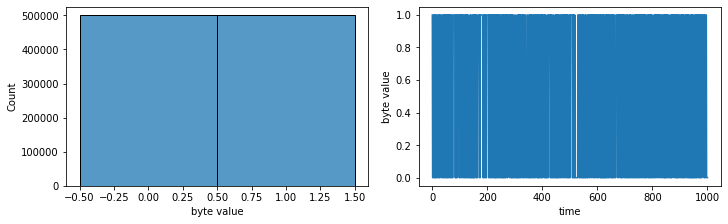

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [ ]:
for path in Path('').rglob(r'*cnt.bin'):
  exp_name = path.parent
  print(exp_name)
  for fn in [last_bit,last_bit_diff]:
    with mlflow.start_run(run_name=exp_name):
      logger.info(f'Doing experiment {exp_name}')
      bytes_data = get_bytes_data(path)
      analyze_series(bytes_data,postprocess_fn=fn)